In [1]:
%matplotlib inline
from cox import readers
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np
sns.set()

In [2]:
r = readers.CollectionReader('agents')

100%|██████████| 80/80 [00:12<00:00,  6.44it/s]


In [3]:
metadata = r.df('metadata')
opt = r.df('optimization')

In [4]:
code_level_opts = {
      'clip_eps': [0.2, 1e10],
      'value_clipping': [False, True],
      'norm_rewards': ["none", "returns"],
      'anneal_lr': [False, True],
      #'initialization': ['xavier', 'orthogonal']
}

NUM_BINS = 20

In [5]:
key_metadata = metadata[['exp_id', 'game', 'clip_eps', 'value_clipping', 'norm_rewards', 'anneal_lr']]

# Code for extracting histogram and scalars

In [10]:
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator

def show_histogram(exp_ids, figure_title=''):
    aggregate_approx_values = []
    total_counts = 0
    for exp_id in exp_ids:
        path = 'agents/%s/tensorboard' % exp_id
        event_acc = EventAccumulator(path, size_guidance={
            'histograms': 25,
        })
        event_acc.Reload()
        histograms = event_acc.Histograms('normalized_advantages')
        for h in histograms:
            bucket_limit = np.array(h.histogram_value.bucket_limit)
            bucket_counts = np.array(h.histogram_value.bucket).astype(np.int)
            aggregate_approx_values.append(np.repeat(bucket_limit, bucket_counts))
            total_counts += bucket_counts.sum()
    aggregate_approx_values = np.array(aggregate_approx_values)
    sns.distplot(aggregate_approx_values.flatten())
    plt.title(figure_title)
    plt.show()
    
def extract_scalar(exp_ids, scalar_name):
    scalars = []
    for exp_id in exp_ids:
        path = 'agents/%s/tensorboard' % exp_id
        event_acc = EventAccumulator(path, tf_size_guidance)
        event_acc.Reload()
        scalars.append(event_acc.Scalars(scalar_name))
    return np.array(scalars).flatten()

In [9]:
exp_id_lookup.head()

,game,clip_eps,value_clipping,norm_rewards,anneal_lr,exp_id
0,Walker2d-v2,0.2,False,none,False,"[ddb16d5a-469d-495d-aacd-87a00f3591eb, be47510..."
1,Walker2d-v2,0.2,False,none,True,"[9fdb47aa-3077-44c7-987f-9c699dfe0cf0, cf91cfd..."
2,Walker2d-v2,0.2,False,returns,False,"[f0e2a0fa-8e42-476c-94b6-7603a5ddec7c, 33d8c3c..."
3,Walker2d-v2,0.2,False,returns,True,"[8b0c37cb-c6bb-4ce9-b1b0-a6e8f192322d, 06b91aa..."
4,Walker2d-v2,0.2,True,none,False,"[bdc5bd4f-e361-48e6-815c-e0f9fc645a71, 2958ebc..."


In [ ]:
extract_scalar(['ddb16d5a-469d-495d-aacd-87a00f3591eb'], 'kurtosis')

# Advantage Distribution, aggregated

In [6]:
exp_id_lookup = key_metadata.groupby(
    ['game', 'clip_eps', 'value_clipping', 'norm_rewards', 'anneal_lr'])['exp_id'].apply(list)
exp_id_lookup = exp_id_lookup.reset_index()

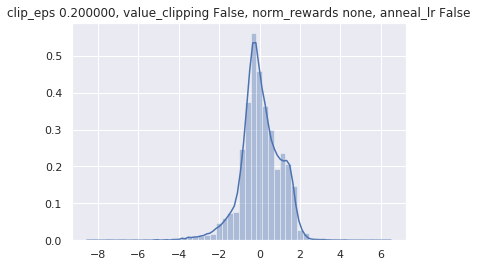

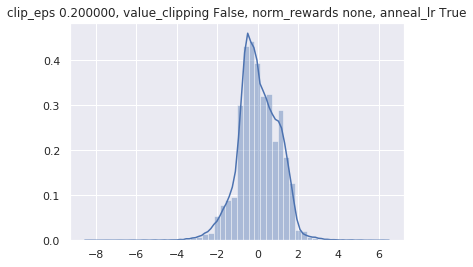

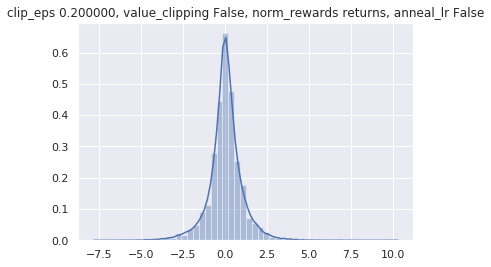

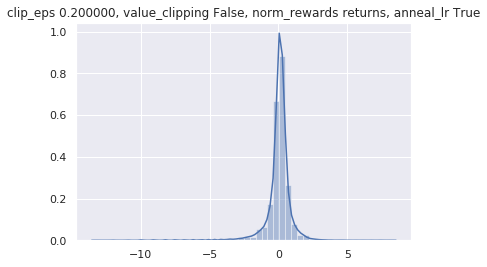

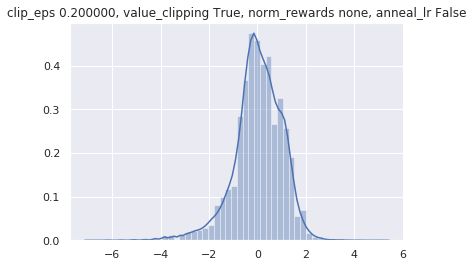

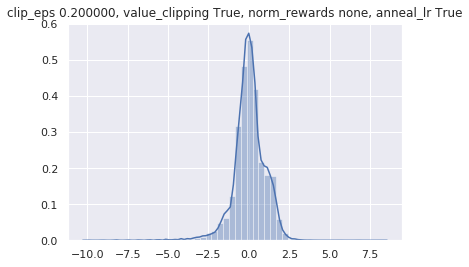

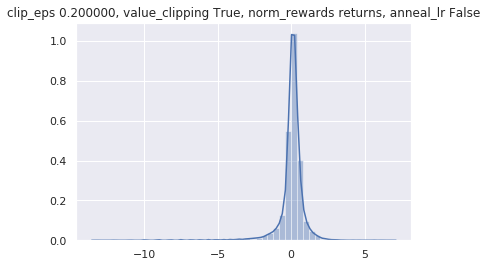

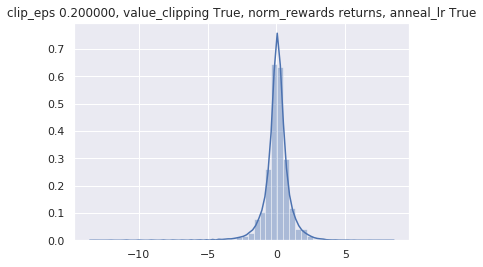

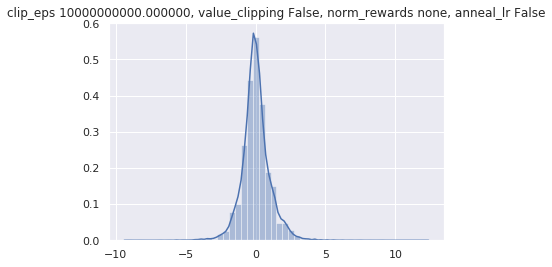

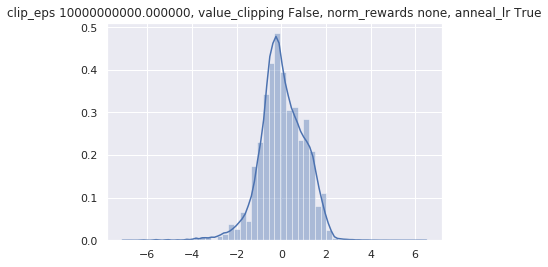

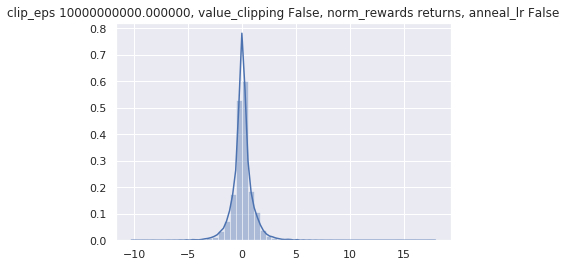

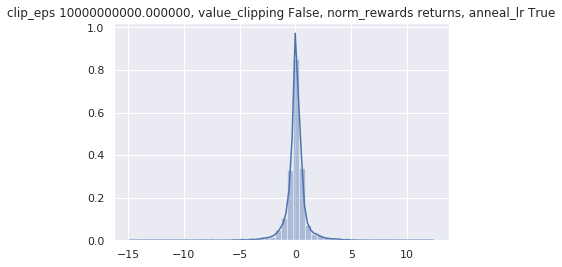

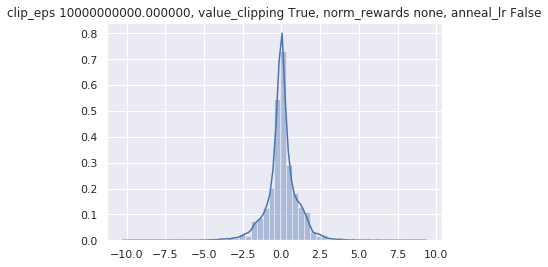

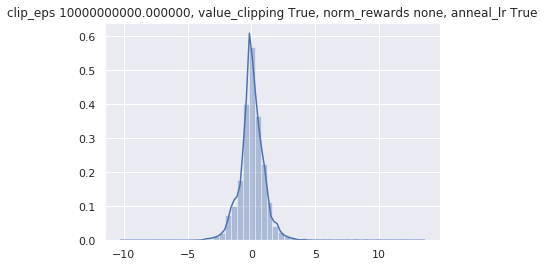

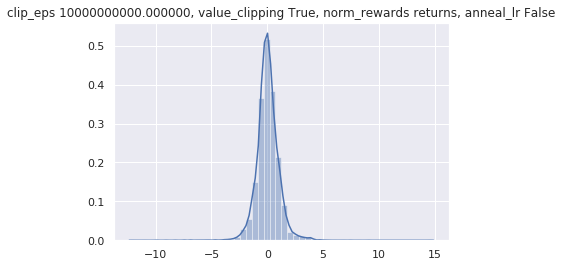

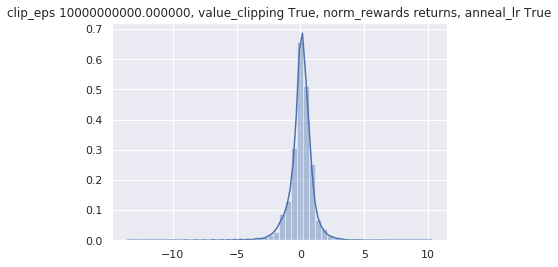

In [28]:
for i, row in exp_id_lookup.iterrows():
    title = "clip_eps %f, value_clipping %s, norm_rewards %s, anneal_lr %s" % (
        row.clip_eps, row.value_clipping, row.norm_rewards, row.anneal_lr)
    show_histogram([row.exp_id[0]], figure_title=title)

# Plot Results (using max reward)

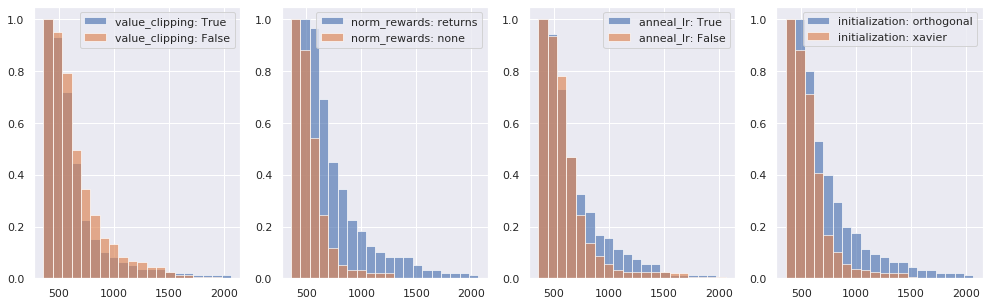

In [49]:
max_rewards = opt.groupby('exp_id').max()

# Histogram setup
_, bin_edges = np.histogram(max_rewards['mean_reward'].tolist(), NUM_BINS)
bin_locs = (bin_edges[:-1] + bin_edges[1:]) / 2
bin_ws = (bin_edges[1] - bin_edges[0])

# Plot setup
kwargs = {'width': bin_ws, 'alpha': 0.65}
fig, ax = plt.subplots(1, 4, figsize=(17,5))

for i, cl_opt in enumerate(code_level_opts):
    for b in reversed(code_level_opts[cl_opt]):
        exp_ids = set(metadata[metadata[cl_opt] == b]['exp_id'].tolist())
        filt = max_rewards[max_rewards.index.isin(exp_ids)]
        hist, _ = np.histogram(filt['mean_reward'].tolist(), bin_edges)
        hist = np.flip(np.cumsum(np.flip(hist))) / np.sum(hist)
        ax[i].bar(bin_locs, hist, label=f"{cl_opt}: {b}", **kwargs)
    ax[i].legend()
plt.show()

# Aggregate performance (max over learning rates, avg over trials)

In [74]:
ks = list(code_level_opts.keys())
grouped_1 = max_rewards.merge(metadata, on='exp_id').groupby(ks + ['ppo_lr_adam']).mean().reset_index().set_index('mean_reward')
grouped_2 = grouped_1.groupby(list(code_level_opts.keys())).idxmax()
grouped_2

ppo_lr_adam  \
value_clipping norm_rewards anneal_lr initialization                
False          none         False     orthogonal       513.242945   
                                      xavier           448.616458   
                            True      orthogonal       530.869896   
                                      xavier           438.276153   
               returns      False     orthogonal       710.097404   
                                      xavier           588.772932   
                            True      orthogonal       980.319935   
                                      xavier           622.461928   
True           none         False     orthogonal       488.035897   
                                      xavier           416.670703   
                            True      orthogonal       523.527723   
                                      xavier           416.366060   
               returns      False     orthogonal       649.272771   
                                      xavier           593.964707   
                            True      orthogonal       757.220427   
                                      xavier           628.480927   

                                                      final_value_loss  \
value_clipping norm_rewards anneal_lr initialization                     
False          none         False     orthogonal            513.242945   
                                      xavier                448.616458   
                            True      orthogonal           1093.424613   
                                      xavier                461.608014   
               returns      False     orthogonal            591.777176   
                                      xavier                688.112929   
                            True      orthogonal            556.167851   
                                      xavier                590.891464   
True           none         False     orthogonal            488.035897   
                                      xavier                416.670703   
                            True      orthogonal            760.434358   
                                      xavier                416.366060   
               returns      False     orthogonal            588.585160   
                                      xavier                757.605252   
                            True      orthogonal            510.167218   
                                      xavier                586.901349   

                                                        mean_std  \
value_clipping norm_rewards anneal_lr initialization               
False          none         False     orthogonal      600.091058   
                                      xavier          733.320232   
                            True      orthogonal      515.179413   
                                      xavier          547.515904   
               returns      False     orthogonal      591.777176   
                                      xavier          688.112929   
                            True      orthogonal      556.167851   
                                      xavier          590.891464   
True           none         False     orthogonal      570.957247   
                                      xavier          637.542162   
                            True      orthogonal      517.396003   
                                      xavier          531.414338   
               returns      False     orthogonal      588.585160   
                                      xavier          627.973160   
                            True      orthogonal      510.167218   
                                      xavier          586.901349   

                                                      num_minibatches  \
value_clipping norm_rewards anneal_lr initialization                    
False          none         False     orthogonal           600.091058   
                                  